In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.pylab as pl
# import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import decimal
from scipy.integrate import simps


In [2]:
def moving_avg(x_data,window):
    # return x_data
    return np.convolve(x_data,np.ones(int(window)),'valid')/window


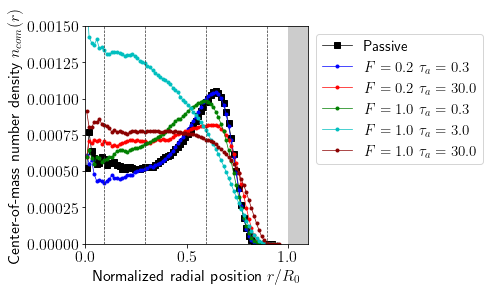

In [24]:
# print(mpl.rcParams.keys)
mpl.rcParams.update({'font.size':16, 'text.usetex':True, 'figure.figsize':(4,4)})
colors = pl.cm.jet_r(np.linspace(0,1,8))
tp=1
ind=3

fpath_free='../../prod_runs/SAC_G1200_N100_R020/analysis/'
fnames_free=sorted([xx for xx in os.listdir(fpath_free) if '.npz' in xx],key=lambda x: float(x.split('_')[ind+1].replace('F','')))

for fpath in ['../../prod_runs/SAC_G1200_N100_R020/analysis/']:#,'../../data_new/SAC_R020/', '../../data_new/RC_R020_N100/']:

    fnames=sorted([xx for xx in os.listdir(fpath) if '.npz' in xx],key=lambda x: float(x.split('_')[ind+1].replace('F','')))
    
    Ts,Tas,Fs=[],[],[]
    Peak,Prob_center=[],[]
    RG=[]
    R_pmax_b=[[],[]]
    p1_eq=0
    rg_eq=0
    jj=0
    for fname in fnames:
        if '.npz' in fname and 'RadNumDens' in fname and 'rep1_' in fname:
            if 'com' not in fname:continue

            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            if T!=200: continue
            Ts.append(T)
            Tas.append(Ta/tp)
            Fs.append(F)

            R_pmax_b[1].append(F**2*Ta/(0.1*200*0.0083))
            
            npzfile=np.load(fpath+fname)
            hist,bins=npzfile['hist'],npzfile['bins']

            n0=int(np.mean([xx for xx in range(len(bins)) if abs(bins[xx]/R0-0.1)<1e-2]))
            n1=int(np.mean([xx for xx in range(len(bins)) if abs(bins[xx]/R0-0.3)<1e-2]))
            n2=int(np.mean([xx for xx in range(len(bins)) if abs(bins[xx]/R0-0.6)<1e-2]))
            n3=int(np.mean([xx for xx in range(len(bins)) if abs(bins[xx]/R0-0.9)<1e-2]))

            Nrep=1
            for index in range(2,20):
                fname_rep=fname.replace('rep1','rep{}'.format(index))

                if fname_rep in fnames:
                    # print(fname_rep)
                    repfile=np.load(fpath+fname_rep)
                    try:
                        hist+=repfile['hist'][:len(hist)]
                        Nrep+=1
                    except(ValueError,):
                        val=repfile['hist']
                        hist+=np.pad(val, (0,hist.shape[0]-val.shape[0]))
                        Nrep+=1
            if 'com' not in fname: hist=hist/(Nrep)
            else: hist=hist/(Nrep)

            #find mean rg
            rg_vals=[]
            for fn_rg in fnames_free:
                if '.npz' in fn_rg and 'shape' in fn_rg:
                    row=fn_rg.split('_')
                    if 'T{}'.format(T) in row and 'F{}'.format(F) in row and 'Ta{}'.format(Ta) in row:
                        npz_rg=np.load(fpath_free+fn_rg)
                        [hist_rg, bins_rg]=npz_rg['rg']
                        rgi=simps(hist_rg*bins_rg,bins_rg)
                        rg_vals.append(rgi)
            rgmean=20#np.mean(rg_vals)
            RG.append(np.mean(rg_vals))

            
            #!!!
            r_pmax=[bins[x] for x,y in enumerate(hist) if y==hist[1:].max()]
            # print(len(r_pmax))
            R_pmax_b[0].append(r_pmax[0])

            dp=np.gradient(hist)/np.gradient(bins)

            p1=simps(bins[n0:n1]**2*4*np.pi*hist[n0:n1]/12,bins[n0:n1])
            # p3=simps(bins[nmid:]**2*4*np.pi*hist[nmid:]/12,bins[nmid:])

            #check at boundary if there is a peak: dp should cross zero once
            cross_count_dp=0
            for ix in range(n2,n3):
                if np.sign(dp[ix])!=np.sign(dp[ix+1]):
                    cross_count_dp+=1

            state=None
            if cross_count_dp==1: state='boundary-peak'
            elif cross_count_dp>1: state='coex'
            else: state='eq-like'
            Peak.append(state)
            Prob_center.append(p1)

            if F==0: 
                # hist=moving_avg(hist,4)
                # plt.plot(bins[:len(hist)]/20,hist, 'k.-',lw=1,label='$F={}\ (\\tau_a={})$'.format(F,Ta),)
                
                plt.plot(bins/R0,hist, 'ks-',lw=0.7,label='Passive',zorder=1)
                p1_eq=p1
                rg_eq=np.mean(rg_vals)
                # print(fname,F,Ta,p1,Nrep)

            for fval,taval,col in [(1,30,'darkred'),(0.2,0.3,'b'),(0.2,30,'red'),(1,3,'c'),(1,0.3,'g')]:
                if (F==fval and Ta==taval):
                    plt.plot(bins/R0,hist, '.-',lw=0.7,label='$F={}\ \\tau_a={}$'.format(F,Ta),c=col,)
            # if F==0.2:
            #     plt.plot(bins/R0,hist, '.-',lw=0.7,label='$F={}\ \\tau_a={}$'.format(F,Ta))#,c=col,)
            #     print(F,Ta,cross_count_dp)
    
plt.xlim(0,1.1)
# plt.ylim(-3e-4,2e-4)
plt.ylim(0,0.0015)
plt.xlabel('Normalized radial position $r/R_0$')
plt.ylabel('Center-of-mass number density $n_{com}(r)$')
plt.legend(loc='upper left',ncol=1, bbox_to_anchor=(1.,1.),fontsize=15)
# plt.axvline(bins[n1]/R0,c='0.2',ls='--',lw=0.7)
plt.axvline(bins[n2]/R0,c='0.2',ls='--',lw=0.7)

plt.axvline(bins[n0]/R0,c='0.2',ls='--',lw=0.7)
plt.axvline(bins[n1]/R0,c='0.2',ls='--',lw=0.7)
plt.axvline(bins[n3]/R0,c='0.2',ls='--',lw=0.7)

plt.axhline(0, c='k',ls='--', lw=0.7)
# plt.axvspan(0.5,0.78,color='0.8')
plt.axvspan(1,1.2,color='0.8')

plt.savefig(fpath+'../plots/comRDP.png', dpi=300, bbox_inches='tight')


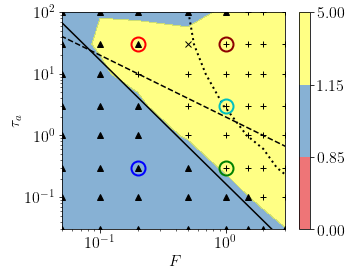

In [25]:
mpl.rcParams.update({'font.size':16, 'text.usetex':True, 'figure.figsize':(5,4)})

# Xi,Yi=np.meshgrid(np.geomspace(0.01,5,40),np.logspace(-2,3,40))
Xi,Yi=np.meshgrid(np.unique(Fs),np.unique(Tas))
# Xi,Yi=np.meshgrid(np.unique(conf),np.unique(betas))
Xp,Yp=np.meshgrid(np.logspace(-4,1,200), np.logspace(-2,4,200))
triang=tri.Triangulation(Fs,Tas)
# triang=tri.Triangulation(conf,betas)
interpZ=tri.LinearTriInterpolator(triang,np.array(Prob_center)/p1_eq)
Zi=interpZ(Xi,Yi)

# plt.contourf(Xi, Yi, Zi, levels=np.arange(0.0,1.5,0.001),cmap='jet',)
plt.contourf(Xi, Yi, Zi, levels=[0.0, 0.85,1.15,5],cmap='Set1',alpha=0.6,)
plt.colorbar()
# plt.contourf(Xi, Yi, Zi, levels=[1.05,3],colors='none',hatches=['/'],)

interpRG=tri.LinearTriInterpolator(triang,np.array(RG)/20)
Zrg=interpRG(Xi,Yi)
plt.contour(Xi, Yi, Zrg, levels=[0.25,0.5],linewidths=2, colors='k',linestyles='dotted')
plt.contour(Xp,Yp,Xp**2*Yp*tp/(0.1*0.0083*200), levels=[1],colors='k')
# plt.axhline(10,c='k',ls='--')

plt.contour(Xp,Yp,Xp*Yp*tp/(0.1*20), levels=[1],colors='k',linestyles='dashed')
# plt.contour(Xi,Yi,Yi/(20*Xi), levels=[1],colors='r',alpha=0.8)

for ix in range(len(Fs)):
    if Peak[ix]=='eq-like':
        plt.plot(Fs[ix],Tas[ix],'k+',)
    elif Peak[ix]=='boundary-peak':
        plt.plot(Fs[ix],Tas[ix],'k^',)
    elif Peak[ix]=='coex':
        plt.plot(Fs[ix],Tas[ix],'kx',)
    else: print(Fs[ix],Tas[ix])

for fval,taval,col in [(1,30,'darkred'),(0.2,0.3,'b'),(0.2,30,'red'),(1,3,'c'),(1,0.3,'g')]:
    plt.plot(fval,taval, 'o',c=col,markerfacecolor='none',markersize=14,linewidth=3,markeredgewidth=2)

plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)


plt.loglog()
# plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.05,max(Fs))
plt.ylim(min(Tas),max(Tas))
# plt.axhline(10,c='k')
plt.savefig(fpath+'../plots/comRDP_regime_diag.png', dpi=300, bbox_inches='tight')
# 

2
56


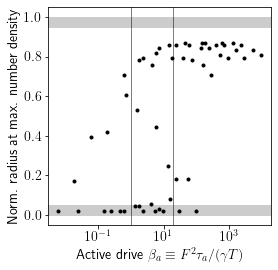

In [133]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True, 'figure.figsize':(4,4)})
#fig,[ax1,ax2,ax]=plt.subplots(1,3,figsize=(15,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})
print(len(R_pmax_b))
colors = pl.cm.gist_rainbow(np.linspace(0,1,len(R_pmax_b[0])))

Yy=[y/20 for x,y in sorted(zip(Fs,R_pmax_b[0]))]
Xx =[y for x,y in sorted(zip(Fs,R_pmax_b[1]))]
print(len(Yy))
plt.semilogx(Xx,Yy,'k.',)
plt.ylim(-0.05,1.05)
# plt.axvspan(1,20,color='0.8',)
plt.axvline(1,c='k',lw=0.5)
plt.axvline(20,c='k',lw=0.5)
plt.axhspan(0,1/20,color='0.8')
plt.axhspan(19/20,1,color='0.8')
plt.xlabel('Active drive $\\beta_a\\equiv F^2\\tau_a/(\\gamma T)$')
plt.ylabel('Norm. radius at max. number density')
plt.savefig(fpath+'plots/R_maxPcom_beta.png', dpi=300, bbox_inches='tight')


0 0 0


ValueError: z array must have same length as triangulation x and y arrays

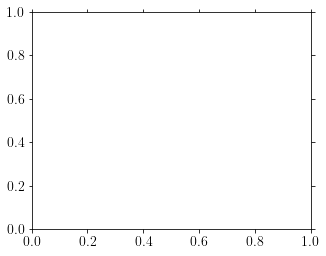